In [1]:
%load_ext autoreload
%autoreload 2

In [99]:
import pandas as pd
import os
from dotenv import load_dotenv
from tqdm import tqdm
import mteb
import json
import matplotlib.pyplot as plt
import datasets
from utils import get_query_and_corpus, print_for_eval, get_cos_sim, add_cos_sim_column
from llms import get_claude_queries
from sentence_transformers import SentenceTransformer, util
import chromadb
from chromadb.utils import embedding_functions
from evals import embed_corpus, retrieve, get_metrics, evaluate, evaluate_new
from multiprocessing import cpu_count
from concurrent.futures import ThreadPoolExecutor
import threading
from typing import List
import numpy as np
import requests
import cohere
import voyageai
from openai import OpenAI
import torch
from embedding_funcs import process_in_batches_voyage_no_input, jina_process_in_batches_no_input, jina_process_in_batches_input_type, process_in_batches_voyage_input_type, minilm_embed_batch

#### Load in data & define functions

In [25]:
all_queries = datasets.load_dataset("ellamind/wikipedia-2023-11-retrieval-multilingual-queries", "en")
all_corpus = datasets.load_dataset("ellamind/wikipedia-2023-11-retrieval-multilingual-corpus", "en")
all_qrels = datasets.load_dataset("ellamind/wikipedia-2023-11-retrieval-multilingual-qrels", "en")

all_queries_df = all_queries["test"].to_pandas()
all_corpus_df = all_corpus["test"].to_pandas()
all_qrels_df = all_qrels["test"].to_pandas()

all_corpus_text = all_corpus_df["text"].tolist()
all_corpus_ids = all_corpus_df["_id"].tolist()

In [43]:
all_qrels_df = all_qrels_df[all_qrels_df["score"] == 1]
all_qrels_df

,query-id,corpus-id,score
4,q20231101.en_45492650_20,20231101.en_45492650_20,1.0
13,q20231101.en_5843419_78,20231101.en_5843419_78,1.0
22,q20231101.en_5058739_82,20231101.en_5058739_82,1.0
31,q20231101.en_62676_84,20231101.en_62676_84,1.0
40,q20231101.en_8841749_25,20231101.en_8841749_25,1.0
...,...,...,...
13459,q20231101.en_431272_20,20231101.en_431272_20,1.0
13468,q20231101.en_1288246_4,20231101.en_1288246_4,1.0
13477,q20231101.en_3684349_61,20231101.en_3684349_61,1.0
13486,q20231101.en_159168_15,20231101.en_159168_15,1.0


In [7]:
batch_size = 100
k_values = [1, 3, 5, 10]

In [125]:
def new_get_results(collection, queries_text, queries_ids, queries_embeddings):
    results = dict()

    for i in tqdm(range(0, len(queries_embeddings), batch_size), desc="Processing batches"):
        batch_text = queries_text[i:i + batch_size]
        batch_ids = queries_ids[i:i + batch_size]
        batch_embeddings = queries_embeddings[i:i + batch_size]

        query_results = collection.query(
            query_embeddings=batch_embeddings,
            query_texts=batch_text,
            n_results=10
        )

        for idx, (query_id, query_embedding) in enumerate(zip(batch_ids, batch_embeddings)):

            results[query_id] = {
                "query_embdding": query_embedding,
                "retrieved_corpus_ids": query_results["ids"][idx],
                "retrieved_corpus_text": query_results["documents"][idx],
                "all_scores": [1 - d for d in query_results["distances"][idx]]
            }

    return results


def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


def calculate_similarity_scores(query_embeddings_dict, corpus_embeddings_dict, output_path=None):
    similarity_scores = []

    for _, row in all_qrels_df.iterrows():
        query_id = row['query-id']
        corpus_id = row['corpus-id']
        
        query_embedding = query_embeddings_dict[query_id]
        corpus_embedding = corpus_embeddings_dict[corpus_id]
        
        similarity = cosine_similarity(query_embedding, corpus_embedding).item()
        similarity_scores.append(similarity)

    scores_df = all_qrels_df.copy()
    scores_df['score'] = similarity_scores

    if output_path:
        scores_df.to_parquet(output_path)
        
    return scores_df


def get_query_text(id):
    return all_queries_df[all_queries_df["_id"] == id]["text"].iloc[0]


def get_corpus_text(id):
    return all_corpus_df[all_corpus_df["_id"] == id]["text"].iloc[0]


def query(collection, query_dict, query_id):
    query_embedding = query_dict[query_id]

    query_result = collection.query(
        query_embeddings=query_embedding,
        n_results=10
    )

    retrieved_docs = ""

    for i, (doc_id, doc, score) in enumerate(zip(query_result["ids"][0], 
                                                query_result["documents"][0],
                                                [1 - d for d in query_result["distances"][0]])):
        retrieved_docs += f"{doc_id}, score: {score}, doc: {doc}\n\n"
    
    return retrieved_docs

def create_combined_metrics_df(og_metrics, gen_metrics):
    og_metrics_df = pd.DataFrame.from_dict({
        k: [value]
        for metrics in og_metrics.values()
        for k, value in metrics.items()
    })

    gen_metrics_df = pd.DataFrame.from_dict({
        k: [value]
        for metrics in gen_metrics.values()
        for k, value in metrics.items()
    })

    combined_metrics_df = pd.concat([
        og_metrics_df.assign(type="original"),
        gen_metrics_df.assign(type="generated")
    ])
    
    metric_cols = ["type", "NDCG@1", "NDCG@3", "NDCG@5", "NDCG@10", 
                  "MAP@3", "MAP@5", "MAP@10", 
                  "Recall@3", "Recall@5", "Recall@10",
                  "P@3", "P@5", "P@10"]
    combined_metrics_df = combined_metrics_df[metric_cols]
    
    return combined_metrics_df

def is_success(corpus_id, result):
    first_id = result.split(", ")[0]
    return corpus_id == first_id

In [9]:
chroma_client = chromadb.HttpClient(
  ssl=True,
  host='api.trychroma.com',
  tenant='',
  database='wikien',
  headers={
    'x-chroma-token': ''
  }
)

#### Generate 1500 queries

In [10]:
all_qrels_df

,query-id,corpus-id,score
4,q20231101.en_45492650_20,20231101.en_45492650_20,1.0
13,q20231101.en_5843419_78,20231101.en_5843419_78,1.0
22,q20231101.en_5058739_82,20231101.en_5058739_82,1.0
31,q20231101.en_62676_84,20231101.en_62676_84,1.0
40,q20231101.en_8841749_25,20231101.en_8841749_25,1.0
...,...,...,...
13459,q20231101.en_431272_20,20231101.en_431272_20,1.0
13468,q20231101.en_1288246_4,20231101.en_1288246_4,1.0
13477,q20231101.en_3684349_61,20231101.en_3684349_61,1.0
13486,q20231101.en_159168_15,20231101.en_159168_15,1.0


In [116]:
qrels_with_text = pd.merge(all_qrels_df, all_queries_df, left_on="query-id", right_on="_id", how="left")
qrels_with_text = pd.merge(qrels_with_text, all_corpus_df, left_on="corpus-id", right_on="_id", how="left")

In [117]:
qrels_with_text.rename(columns={"text_x": "query_text", "text_y": "corpus_text"}, inplace=True)
qrels_with_text.drop(columns=["_id_x", "_id_y", "title"], inplace=True)
qrels_with_text

,query-id,corpus-id,score,query_text,corpus_text
0,q20231101.en_45492650_20,20231101.en_45492650_20,1.0,"What is the focus of the 2023 documentary ""Mon...","A 2023 documentary, Money Shot: The Pornhub St..."
1,q20231101.en_5843419_78,20231101.en_5843419_78,1.0,What are the components of the French Armed Fo...,The French Armed Forces () are the military an...
2,q20231101.en_5058739_82,20231101.en_5058739_82,1.0,What types of crimes are most common in Sweden...,"According to a victimisation survey of 1,201 r..."
3,q20231101.en_62676_84,20231101.en_62676_84,1.0,What terms does WWE use to describe their fan ...,WWE uses a variety of special terms in promoti...
4,q20231101.en_8841749_25,20231101.en_8841749_25,1.0,What operating system does the iPhone use?,The iPhone runs iOS. It is based on macOS's Da...
...,...,...,...,...,...
1495,q20231101.en_431272_20,20231101.en_431272_20,1.0,What territories were administered by the Brit...,"Territories of Zambesia and Rhodesia, administ..."
1496,q20231101.en_1288246_4,20231101.en_1288246_4,1.0,What are the top destinations to visit in Krab...,Much of the province has been given over to se...
1497,q20231101.en_3684349_61,20231101.en_3684349_61,1.0,Why did Apple stop licensing data from TomTom ...,"As part of the MEP program, users provide feed..."
1498,q20231101.en_159168_15,20231101.en_159168_15,1.0,What happened in Cirencester during the Englis...,The English Civil War came to Cirencester in F...


In [143]:
def create_combined_df(col, og_queries_embeddings_dict, gen_queries_embeddings_dict, og_scores_df, gen_scores_df):
    merged_scores_df = pd.merge(og_scores_df, gen_scores_df, on="query-id", how="left")
    merged_scores_df.rename(columns={"score_x": "og_score", "score_y": "gen_score"}, inplace=True)
    merged_scores_df.drop(columns=["corpus-id_y"], inplace=True)
    merged_scores_df.rename(columns={"corpus-id_x": "corpus-id"}, inplace=True)
    merged_df = pd.merge(qrels_with_text, merged_scores_df, on="query-id", how="left")
    merged_df.drop(columns=["corpus-id_y", "score"], inplace=True)
    merged_df["og - gen"] = merged_df["og_score"] - merged_df["gen_score"]

    tqdm.pandas()
    merged_df["og_query_result"] = merged_df.progress_apply(lambda row: query(col, og_queries_embeddings_dict, row["query-id"]), axis=1)
    merged_df["gen_query_result"] = merged_df.progress_apply(lambda row: query(col, gen_queries_embeddings_dict, row["query-id"]), axis=1)

    merged_df["og_success"] = merged_df.apply(lambda row: is_success(row["corpus-id"], row["og_query_result"]), axis=1)
    merged_df["gen_success"] = merged_df.apply(lambda row: is_success(row["corpus-id"], row["gen_query_result"]), axis=1)
    
    return merged_df


In [13]:
query_corpus_dict = {
    row["query-id"]: {
        "query_text": row["query_text"],
        "corpus_text": row["corpus_text"]
    }
    for _, row in qrels_with_text.iterrows()
}

In [14]:
gen_query_corpus_dict = dict()

In [21]:
full_qrels = pd.read_parquet("generated_all/full_qrels.parquet")
full_qrels.head()

,query-id,corpus-id,og_query_text,gen_query_text,corpus_text
0,q20231101.en_189891_13,20231101.en_189891_13,What is the significance of Llyn Ffynnon-y-gwa...,How was the reservoir's water level and volume...,"Llyn Ffynnon-y-gwas – high, – lies in Cwm Tr..."
1,q20231101.en_49708_58,20231101.en_49708_58,When did Xi Jinping and Ma Ying-jeou first for...,Who were the leaders that participated in the ...,November 7 – CPC general secretary Xi Jinping ...
2,q20231101.en_237746_29,20231101.en_237746_29,What is excited delirium and how is it related...,What factors or pre-existing conditions make i...,Some of the deaths associated with TASER devic...
3,q20231101.en_15809706_5,20231101.en_15809706_5,What is the incidence rate of thyroid tumors i...,What was the relationship between pre-existing...,At exposures eight times greater than those us...
4,q20231101.en_233369_67,20231101.en_233369_67,What types of sweets are made in Nablus?,What ingredients are used to make ghuraybeh pa...,"Other sweets made in Nablus include baklawa, ""..."


In [24]:
og_queries_text = full_qrels["og_query_text"].tolist()
all_queries_ids = full_qrels["query-id"].tolist()
gen_queries_text = full_qrels["gen_query_text"].tolist()

In [24]:
for query_id, query_info in tqdm(query_corpus_dict.items(), desc="Processing queries"):
    if query_id not in gen_query_corpus_dict:
        generated_query = get_claude_queries(query_info["query_text"], query_info["corpus_text"])
        gen_query_corpus_dict[query_id] = {
            "original_query": query_info["query_text"],
            "corpus_text": query_info["corpus_text"],
            "generated_query": generated_query
        }

Processing queries: 100%|██████████| 1500/1500 [10:50<00:00,  2.31it/s] 


In [25]:
len(gen_query_corpus_dict.keys())

1500

In [26]:
gen_queries_text = [gen_query_corpus_dict[query_id]["generated_query"] for query_id in all_queries_ids]

In [52]:
gen_query_corpus_dict

{'q20231101.en_45492650_20': {'original_query': 'What is the focus of the 2023 documentary "Money Shot: The Pornhub Story"?',
  'corpus_text': 'A 2023 documentary, Money Shot: The Pornhub Story, covers the opposition to Pornhub and the views of pornographic performers. It interviews Kristof, a lawyer representing women suing MindGeek and a spokesperson to the anti-sex-trafficking group National Center on Sexual Exploitation.',
  'generated_query': 'Who were some of the key people interviewed in "Money Shot: The Pornhub Story"?'},
 'q20231101.en_5843419_78': {'original_query': 'What are the components of the French Armed Forces?',
  'corpus_text': "The French Armed Forces () are the military and paramilitary forces of France, under the President of the Republic as supreme commander. They consist of the French Army (), the French Navy (Marine Nationale, formerly called Armée de Mer), the French Air and Space Force (Armée de l'Air et de l’Espace), and the National Gendarmerie (Gendarmerie

## Generate 1500 queries: text-embedding-3-small

#### 1. Run benchmark over ground truth queries

just to confirm results

In [64]:
openai_small_col = chroma_client.get_collection("openai_small")

openai_client = OpenAI(api_key="")

def openai_embed_batch_query(texts: List[str], model: str) -> List[List[float]]:
    return [d.embedding for d in openai_client.embeddings.create(model=model, input = texts).data]

def openai_process_in_batches(texts: List[str], model: str, batch_size: int = 100) -> List[List[float]]:
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing openai batches"):
        batch = texts[i:i + batch_size]
        batch_embeddings = openai_embed_batch_query(batch, model)
        all_embeddings.extend(batch_embeddings)

    return all_embeddings

In [16]:
openai_small_queries_embeddings = openai_process_in_batches(og_queries_text, model="text-embedding-3-small")

openai_small_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, openai_small_queries_embeddings)
}

Processing openai batches: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


In [10]:
openai_small_corpus_embeddings_dict = {}

for i in tqdm(range(0, len(all_corpus_ids), batch_size), desc="Processing batches"):
    batch_ids = all_corpus_ids[i:i + batch_size]
    results = openai_small_col.get(ids=batch_ids, include=["embeddings"])
    batch_embeddings = results["embeddings"]
    retrieved_ids = results["ids"]
    
    for corpus_id, embedding in zip(retrieved_ids, batch_embeddings):
        openai_small_corpus_embeddings_dict[corpus_id] = embedding

openai_small_entire_benchmark_results = new_get_results(openai_small_col, og_queries_text, all_queries_ids, openai_small_queries_embeddings)
openai_small_entire_benchmark_metrics = evaluate_new(k_values, all_qrels_df, openai_small_entire_benchmark_results)

with open("generated_all/openai_small_original_metrics.json", "w") as f:
    json.dump(openai_small_entire_benchmark_metrics, f, indent=4)

openai_small_entire_benchmark_metrics

Processing batches: 100%|██████████| 15/15 [00:39<00:00,  2.62s/it]


{'NDCG': {'NDCG@1': 0.84333,
  'NDCG@3': 0.90255,
  'NDCG@5': 0.9115,
  'NDCG@10': 0.91945},
 'MAP': {'MAP@1': 0.84333, 'MAP@3': 0.888, 'MAP@5': 0.8929, 'MAP@10': 0.89641},
 'Recall': {'Recall@1': 0.84333,
  'Recall@3': 0.94467,
  'Recall@5': 0.96667,
  'Recall@10': 0.99},
 'Precision': {'P@1': 0.84333, 'P@3': 0.31489, 'P@5': 0.19333, 'P@10': 0.099}}

In [115]:
openai_small_entire_benchmark_metrics_df = pd.DataFrame.from_dict({
    k: [value]
    for metrics in openai_small_entire_benchmark_metrics.values() 
    for k, value in metrics.items()
})
openai_small_entire_benchmark_metrics_df

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@1,MAP@3,MAP@5,MAP@10,Recall@1,Recall@3,Recall@5,Recall@10,P@1,P@3,P@5,P@10
0,0.84333,0.90255,0.9115,0.91945,0.84333,0.888,0.8929,0.89641,0.84333,0.94467,0.96667,0.99,0.84333,0.31489,0.19333,0.099


In [11]:
openai_small_scores_df = calculate_similarity_scores(
    openai_small_queries_embeddings_dict,
    openai_small_corpus_embeddings_dict,
    "generated_all/openai_small_original_distribution.parquet"
)

openai_small_scores_df

,query-id,corpus-id,score
4,q20231101.en_45492650_20,20231101.en_45492650_20,0.785820
13,q20231101.en_5843419_78,20231101.en_5843419_78,0.728965
22,q20231101.en_5058739_82,20231101.en_5058739_82,0.752374
31,q20231101.en_62676_84,20231101.en_62676_84,0.736448
40,q20231101.en_8841749_25,20231101.en_8841749_25,0.681110
...,...,...,...
13459,q20231101.en_431272_20,20231101.en_431272_20,0.714155
13468,q20231101.en_1288246_4,20231101.en_1288246_4,0.710468
13477,q20231101.en_3684349_61,20231101.en_3684349_61,0.684263
13486,q20231101.en_159168_15,20231101.en_159168_15,0.843605


#### 2. Run over 1500 generated queries

In [ ]:
openai_small_gen_queries_embeddings = openai_process_in_batches(gen_queries_text, model="text-embedding-3-small")

openai_small_gen_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, openai_small_gen_queries_embeddings)
}

openai_small_gen_results = new_get_results(openai_small_col, gen_queries_text, all_queries_ids, openai_small_gen_queries_embeddings)
openai_small_gen_metrics = evaluate_new(k_values, all_qrels_df, openai_small_gen_results)

with open("generated_all/openai_small_gen_metrics.json", "w") as f:
    json.dump(openai_small_gen_metrics, f, indent=4)

openai_small_gen_metrics

Processing batches: 100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


{'NDCG': {'NDCG@1': 0.886,
  'NDCG@3': 0.93412,
  'NDCG@5': 0.94043,
  'NDCG@10': 0.94345},
 'MAP': {'MAP@1': 0.886, 'MAP@3': 0.923, 'MAP@5': 0.9265, 'MAP@10': 0.92774},
 'Recall': {'Recall@1': 0.886,
  'Recall@3': 0.966,
  'Recall@5': 0.98133,
  'Recall@10': 0.99067},
 'Precision': {'P@1': 0.886, 'P@3': 0.322, 'P@5': 0.19627, 'P@10': 0.09907}}

In [114]:
openai_small_gen_metrics_df = pd.DataFrame.from_dict({
    k: [value]
    for metrics in openai_small_gen_metrics.values() 
    for k, value in metrics.items()
})
openai_small_gen_metrics_df

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@1,MAP@3,MAP@5,MAP@10,Recall@1,Recall@3,Recall@5,Recall@10,P@1,P@3,P@5,P@10
0,0.886,0.93412,0.94043,0.94345,0.886,0.923,0.9265,0.92774,0.886,0.966,0.98133,0.99067,0.886,0.322,0.19627,0.09907


In [118]:
openai_small_combined_metrics_df = pd.concat([
    openai_small_entire_benchmark_metrics_df.assign(type="original"),
    openai_small_gen_metrics_df.assign(type="generated")
])
openai_small_combined_metrics_df = openai_small_combined_metrics_df[["type", "NDCG@1", "NDCG@3", "NDCG@5", "NDCG@10", "MAP@3", "MAP@5", "MAP@10", "Recall@3", "Recall@5", "Recall@10", "P@3", "P@5", "P@10"]]
openai_small_combined_metrics_df


,type,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@3,MAP@5,MAP@10,Recall@3,Recall@5,Recall@10,P@3,P@5,P@10
0,original,0.84333,0.90255,0.91150,0.91945,0.888,0.8929,0.89641,0.94467,0.96667,0.99000,0.31489,0.19333,0.09900
0,generated,0.88600,0.93412,0.94043,0.94345,0.923,0.9265,0.92774,0.96600,0.98133,0.99067,0.32200,0.19627,0.09907


In [119]:
openai_small_combined_metrics_df.to_csv("generated_all/openai_small_combined_metrics.csv", index=False)

In [35]:
openai_small_gen_scores_df = calculate_similarity_scores(
    openai_small_gen_queries_embeddings_dict,
    openai_small_corpus_embeddings_dict,
    "generated_all/openai_small_generated_distribution.parquet"
)

openai_small_gen_scores_df

,query-id,corpus-id,score
4,q20231101.en_45492650_20,20231101.en_45492650_20,0.716013
13,q20231101.en_5843419_78,20231101.en_5843419_78,0.639105
22,q20231101.en_5058739_82,20231101.en_5058739_82,0.648838
31,q20231101.en_62676_84,20231101.en_62676_84,0.674286
40,q20231101.en_8841749_25,20231101.en_8841749_25,0.659036
...,...,...,...
13459,q20231101.en_431272_20,20231101.en_431272_20,0.808053
13468,q20231101.en_1288246_4,20231101.en_1288246_4,0.602784
13477,q20231101.en_3684349_61,20231101.en_3684349_61,0.570901
13486,q20231101.en_159168_15,20231101.en_159168_15,0.742326


In [58]:
openai_small_gen_scores_df = pd.read_parquet("generated_all/openai_small_generated_distribution.parquet")

In [60]:
openai_small_scores_df = pd.read_parquet("generated_all/openai_small_original_distribution.parquet")

#### 3. Compare

In [61]:
min_score = min(openai_small_gen_scores_df["score"].min(), openai_small_scores_df["score"].min())
max_score = max(openai_small_gen_scores_df["score"].max(), openai_small_scores_df["score"].max())

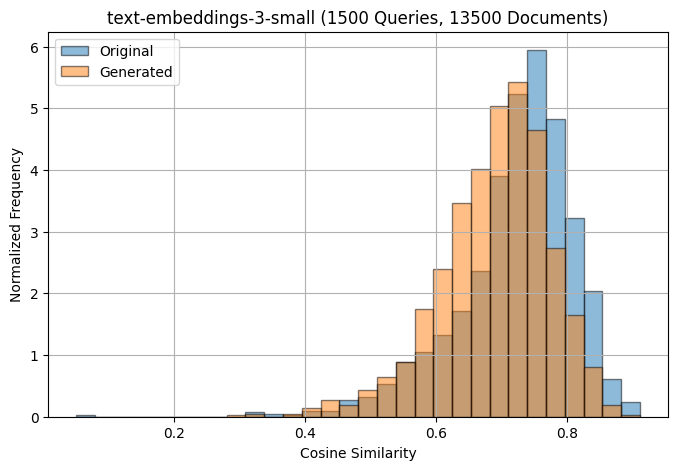

In [62]:
bins=30

plt.figure(figsize=(8, 5))

plt.hist(openai_small_scores_df["score"], bins=bins, alpha=0.5,  edgecolor='black', label="Original", range=(min_score, max_score), density=True)
plt.hist(openai_small_gen_scores_df["score"], bins=bins, alpha=0.5, edgecolor='black', label="Generated", range=(min_score, max_score), density=True)

plt.xlabel("Cosine Similarity")
plt.ylabel("Normalized Frequency")

plt.title("text-embeddings-3-small (1500 Queries, 13500 Documents)")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
openai_small_merged_df = pd.merge(openai_small_scores_df, openai_small_gen_scores_df, on="query-id", how="left")

In [49]:
openai_small_scores_df

,query-id,corpus-id,score
4,q20231101.en_45492650_20,20231101.en_45492650_20,0.785820
13,q20231101.en_5843419_78,20231101.en_5843419_78,0.728965
22,q20231101.en_5058739_82,20231101.en_5058739_82,0.752374
31,q20231101.en_62676_84,20231101.en_62676_84,0.736448
40,q20231101.en_8841749_25,20231101.en_8841749_25,0.681110
...,...,...,...
13459,q20231101.en_431272_20,20231101.en_431272_20,0.714155
13468,q20231101.en_1288246_4,20231101.en_1288246_4,0.710468
13477,q20231101.en_3684349_61,20231101.en_3684349_61,0.684263
13486,q20231101.en_159168_15,20231101.en_159168_15,0.843605


In [50]:
openai_small_merged_df.drop(columns=["corpus-id_y"], inplace=True)
openai_small_merged_df.rename(columns={"score_x": "og_score", "score_y": "gen_score"}, inplace=True)

,query-id,corpus-id_x,og_score,gen_score
0,q20231101.en_45492650_20,20231101.en_45492650_20,0.785820,0.716013
1,q20231101.en_5843419_78,20231101.en_5843419_78,0.728965,0.639105
2,q20231101.en_5058739_82,20231101.en_5058739_82,0.752374,0.648838
3,q20231101.en_62676_84,20231101.en_62676_84,0.736448,0.674286
4,q20231101.en_8841749_25,20231101.en_8841749_25,0.681110,0.659036
...,...,...,...,...
1495,q20231101.en_431272_20,20231101.en_431272_20,0.714155,0.808053
1496,q20231101.en_1288246_4,20231101.en_1288246_4,0.710468,0.602784
1497,q20231101.en_3684349_61,20231101.en_3684349_61,0.684263,0.570901
1498,q20231101.en_159168_15,20231101.en_159168_15,0.843605,0.742326


In [ ]:
openai_small_merged_df.rename(columns={"corpus-id_x": "corpus-id"}, inplace=True)

openai_small_merged_df["og_query_text"] = openai_small_merged_df["query-id"].map(lambda x: gen_query_corpus_dict[x]["original_query"])
openai_small_merged_df["gen_query_text"] = openai_small_merged_df["query-id"].map(lambda x: gen_query_corpus_dict[x]["generated_query"]) 
openai_small_merged_df["corpus_text"] = openai_small_merged_df["query-id"].map(lambda x: gen_query_corpus_dict[x]["corpus_text"])
openai_small_merged_df

In [ ]:
openai_small_merged_df["og - gen"] = openai_small_merged_df["og_score"] - openai_small_merged_df["gen_score"]

In [64]:
openai_small_merged_df.describe()

,og_score,gen_score,og - gen
count,1500.000000,1500.000000,1500.000000
mean,0.720881,0.689518,0.031363
std,0.090178,0.084244,0.092567
min,0.050205,0.295958,-0.329168
25%,0.679621,0.642664,-0.023348
50%,0.737320,0.699701,0.033589
75%,0.782374,0.748349,0.086817
max,0.911743,0.896469,0.373702


In [18]:
openai_small_merged_df

,query-id,corpus-id,og_score,gen_score,og_query_text,gen_query_text,corpus_text,og - gen,og_query_result
0,q20231101.en_189891_13,20231101.en_189891_13,0.749034,0.375332,What is the significance of Llyn Ffynnon-y-gwa...,How was the reservoir's water level and volume...,"Llyn Ffynnon-y-gwas – high, – lies in Cwm Tr...",0.373702,"20231101.en_189891_13, score: 0.74904608726501..."
1,q20231101.en_49708_58,20231101.en_49708_58,0.779723,0.433520,When did Xi Jinping and Ma Ying-jeou first for...,Who were the leaders that participated in the ...,November 7 – CPC general secretary Xi Jinping ...,0.346203,"20231101.en_49708_58, score: 0.779713749885559..."
2,q20231101.en_237746_29,20231101.en_237746_29,0.842045,0.514026,What is excited delirium and how is it related...,What factors or pre-existing conditions make i...,Some of the deaths associated with TASER devic...,0.328019,"20231101.en_237746_29, score: 0.84205657243728..."
3,q20231101.en_15809706_5,20231101.en_15809706_5,0.836615,0.512268,What is the incidence rate of thyroid tumors i...,What was the relationship between pre-existing...,At exposures eight times greater than those us...,0.324347,"20231101.en_15809706_5, score: 0.8365775942802..."
4,q20231101.en_233369_67,20231101.en_233369_67,0.879577,0.569303,What types of sweets are made in Nablus?,What ingredients are used to make ghuraybeh pa...,"Other sweets made in Nablus include baklawa, ""...",0.310274,"20231101.en_233369_67, score: 0.87957692146301..."
...,...,...,...,...,...,...,...,...,...
1495,q20231101.en_54634_5,20231101.en_54634_5,0.443864,0.718574,What is the origin of the name Wednesday?,When did Vettius Valens first document the sev...,The Latin name dates to the late 2nd or early ...,-0.274709,"20231101.en_54634_3, score: 0.7542437314987183..."
1496,q20231101.en_5198123_10,20231101.en_5198123_10,0.050205,0.327206,What is the setting described in the document ...,What physical features does the narrator's bel...,At the other side of the river I have my sand ...,-0.277001,"20231101.en_5198123_7, score: 0.45280873775482..."
1497,q20231101.en_19230475_34,20231101.en_19230475_34,0.489135,0.771994,What is the significance of the Kulkulcan pyra...,Who was Tony Shearer and how did his book 'Lor...,In 1971 Tony Shearer published a book called L...,-0.282859,"20231101.en_19230475_34, score: 0.489159822463..."
1498,q20231101.en_65091_15,20231101.en_65091_15,0.506188,0.820488,What is the scientific name of the pika specie...,What regions of Eastern Europe was Ochotona tr...,†Ochotona transcaucasica (Transcaucasia: easte...,-0.314300,"20231101.en_65091_17, score: 0.617039203643798..."


In [22]:
generated_queries = openai_small_merged_df["gen_query_text"].tolist()
gen_query_ids = openai_small_merged_df["query-id"].tolist()

In [23]:
gen_queries_embeddings = openai_process_in_batches(generated_queries, model="text-embedding-3-small")
gen_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(gen_query_ids, gen_queries_embeddings)
}

Processing openai batches: 100%|██████████| 15/15 [00:29<00:00,  1.93s/it]


In [24]:
tqdm.pandas()
openai_small_merged_df["gen_query_result"] = openai_small_merged_df.progress_apply(lambda row: query(openai_small_col, gen_queries_embeddings_dict, row["query-id"]), axis=1)

100%|██████████| 1500/1500 [03:03<00:00,  8.19it/s]


In [28]:
openai_small_merged_df["og_success"] = openai_small_merged_df.apply(lambda row: is_success(row["corpus-id"], row["og_query_result"]), axis=1)
openai_small_merged_df["gen_success"] = openai_small_merged_df.apply(lambda row: is_success(row["corpus-id"], row["gen_query_result"]), axis=1)
openai_small_merged_df.head()

,query-id,corpus-id,og_score,gen_score,og_query_text,gen_query_text,corpus_text,og - gen,og_query_result,gen_query_result,og_success,gen_success
0,q20231101.en_189891_13,20231101.en_189891_13,0.749034,0.375332,What is the significance of Llyn Ffynnon-y-gwa...,How was the reservoir's water level and volume...,"Llyn Ffynnon-y-gwas – high, – lies in Cwm Tr...",0.373702,"20231101.en_189891_13, score: 0.74904608726501...","20231101.en_1050149_7, score: 0.51412093639373...",True,False
1,q20231101.en_49708_58,20231101.en_49708_58,0.779723,0.433520,When did Xi Jinping and Ma Ying-jeou first for...,Who were the leaders that participated in the ...,November 7 – CPC general secretary Xi Jinping ...,0.346203,"20231101.en_49708_58, score: 0.779713749885559...","20231101.en_49708_58, score: 0.430175304412841...",True,True
2,q20231101.en_237746_29,20231101.en_237746_29,0.842045,0.514026,What is excited delirium and how is it related...,What factors or pre-existing conditions make i...,Some of the deaths associated with TASER devic...,0.328019,"20231101.en_237746_29, score: 0.84205657243728...","20231101.en_237746_30, score: 0.64148318767547...",True,False
3,q20231101.en_15809706_5,20231101.en_15809706_5,0.836615,0.512268,What is the incidence rate of thyroid tumors i...,What was the relationship between pre-existing...,At exposures eight times greater than those us...,0.324347,"20231101.en_15809706_5, score: 0.8365775942802...","20231101.en_15809706_5, score: 0.5122533440589...",True,True
4,q20231101.en_233369_67,20231101.en_233369_67,0.879577,0.569303,What types of sweets are made in Nablus?,What ingredients are used to make ghuraybeh pa...,"Other sweets made in Nablus include baklawa, ""...",0.310274,"20231101.en_233369_67, score: 0.87957692146301...","20231101.en_233369_67, score: 0.56935441493988...",True,True


In [30]:
og_success_rate = openai_small_merged_df["og_success"].mean()
gen_success_rate = openai_small_merged_df["gen_success"].mean()
og_success_rate, gen_success_rate

(np.float64(0.8433333333333334), np.float64(0.886))

In [46]:
openai_small_merged_df.sort_values(by="og - gen", ascending=True, inplace=True)

In [47]:
openai_small_merged_df_gen_greater = openai_small_merged_df[openai_small_merged_df["og_success"] == False][:100]
openai_small_merged_df_gen_greater

,query-id,corpus-id,og_score,gen_score,og_query_text,gen_query_text,corpus_text,og - gen,og_query_result,gen_query_result,og_success,gen_success
1499,q20231101.en_4398877_7,20231101.en_4398877_7,0.355916,0.685084,What are the potential severe side effects of ...,Can medications trigger Stevens-Johnson syndro...,It is also one of the medications that can cau...,-0.329168,"20231101.en_4398877_4, score: 0.62591642141342...","20231101.en_4398877_7, score: 0.68509626388549...",False,True
1498,q20231101.en_65091_15,20231101.en_65091_15,0.506188,0.820488,What is the scientific name of the pika specie...,What regions of Eastern Europe was Ochotona tr...,†Ochotona transcaucasica (Transcaucasia: easte...,-0.314300,"20231101.en_65091_17, score: 0.617039203643798...","20231101.en_65091_15, score: 0.820510566234588...",False,True
1496,q20231101.en_5198123_10,20231101.en_5198123_10,0.050205,0.327206,What is the setting described in the document ...,What physical features does the narrator's bel...,At the other side of the river I have my sand ...,-0.277001,"20231101.en_5198123_7, score: 0.45280873775482...","20231101.en_478276_21, score: 0.33074474334716...",False,False
1495,q20231101.en_54634_5,20231101.en_54634_5,0.443864,0.718574,What is the origin of the name Wednesday?,When did Vettius Valens first document the sev...,The Latin name dates to the late 2nd or early ...,-0.274709,"20231101.en_54634_3, score: 0.7542437314987183...","20231101.en_54634_5, score: 0.7185916900634766...",False,True
1494,q20231101.en_208612_8,20231101.en_208612_8,0.544534,0.788989,What basic introductory information is availab...,According to which editions or publications di...,"In Uhl & Dransfield (1987 Genera Palmarum, 2ºe...",-0.244455,"20231101.en_208612_9, score: 0.615943729877471...","20231101.en_208612_8, score: 0.789023220539093...",False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1295,q20231101.en_190961_23,20231101.en_190961_23,0.721412,0.783290,What are the causes of hyponatremia related to...,What are the conditions that lead to hyponatre...,Hyponatremia occurs in one of two ways: either...,-0.061878,"20231101.en_190961_22, score: 0.74533891677856...","20231101.en_190961_23, score: 0.78328210115432...",False,True
1294,q20231101.en_352418_47,20231101.en_352418_47,0.585421,0.646577,What religious denominations were present in B...,When did the first nonconformist congregations...,There is evidence from Saxon times of Christia...,-0.061156,"20231101.en_352418_46, score: 0.60081070661544...","20231101.en_352418_47, score: 0.64656823873519...",False,True
1293,q20231101.en_1119446_4,20231101.en_1119446_4,0.453927,0.514716,"What are the critical reviews of the song ""MMM...",How did Rolling Stone's Chuck Eddy describe th...,"Chuck Eddy of Rolling Stone felt it ""sticks in...",-0.060789,"20231101.en_1119446_5, score: 0.63813155889511...","20231101.en_1119446_4, score: 0.51464939117431...",False,True
1289,q20231101.en_219731_20,20231101.en_219731_20,0.646401,0.704954,How were the sound effects for the game Myst c...,What unusual or everyday objects were used to ...,Chris Brandkamp produced most of the ambient a...,-0.058553,"20231101.en_219731_21, score: 0.68874454498291...","20231101.en_219731_20, score: 0.70495367050170...",False,True


In [48]:
openai_small_merged_df_gen_greater.to_csv("generated_all/openai_small_gen_greater.csv", index=False)

#### (og > gen) original query is more relevant than generated query

In [71]:
openai_small_merged_df.to_csv("generated_all/openai_small_merged_df.csv", index=False)

In [114]:
openai_small_merged_df = pd.read_csv("generated_all/openai_small_merged_df.csv")
openai_small_merged_df.head()

,query-id,corpus-id,og_score,gen_score,og_query_text,gen_query_text,corpus_text,og - gen
0,q20231101.en_189891_13,20231101.en_189891_13,0.749034,0.375332,What is the significance of Llyn Ffynnon-y-gwa...,How was the reservoir's water level and volume...,"Llyn Ffynnon-y-gwas – high, – lies in Cwm Tr...",0.373702
1,q20231101.en_49708_58,20231101.en_49708_58,0.779723,0.433520,When did Xi Jinping and Ma Ying-jeou first for...,Who were the leaders that participated in the ...,November 7 – CPC general secretary Xi Jinping ...,0.346203
2,q20231101.en_237746_29,20231101.en_237746_29,0.842045,0.514026,What is excited delirium and how is it related...,What factors or pre-existing conditions make i...,Some of the deaths associated with TASER devic...,0.328019
3,q20231101.en_15809706_5,20231101.en_15809706_5,0.836615,0.512268,What is the incidence rate of thyroid tumors i...,What was the relationship between pre-existing...,At exposures eight times greater than those us...,0.324347
4,q20231101.en_233369_67,20231101.en_233369_67,0.879577,0.569303,What types of sweets are made in Nablus?,What ingredients are used to make ghuraybeh pa...,"Other sweets made in Nablus include baklawa, ""...",0.310274


In [17]:
tqdm.pandas()
openai_small_merged_df["og_query_result"] = openai_small_merged_df.progress_apply(lambda row: query(openai_small_col, openai_small_queries_embeddings_dict, row["query-id"]), axis=1)

100%|██████████| 1500/1500 [03:36<00:00,  6.94it/s]


In [76]:
openai_small_merged_df.sort_values(by="og - gen", ascending=False, inplace=True)

In [78]:
openai_small_merged_df_og_greater = openai_small_merged_df[:80]

In [107]:
openai_small_merged_df_og_greater["og_query_result"] = openai_small_merged_df_og_greater.progress_apply(lambda row: query(openai_small_col, openai_small_queries_embeddings_dict, row["query-id"]), axis=1)

100%|██████████| 80/80 [00:09<00:00,  8.40it/s]
/var/folders/tt/89j8tbqd2q3bnwxk83_csyn00000gn/T/ipykernel_47666/2973627804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openai_small_merged_df_og_greater["og_query_result"] = openai_small_merged_df_og_greater.progress_apply(lambda row: query(openai_small_col, openai_small_queries_embeddings_dict, row["query-id"]), axis=1)


In [108]:
tqdm.pandas()
openai_small_merged_df_og_greater["gen_query_result"] = openai_small_merged_df_og_greater.progress_apply(lambda row: query(openai_small_col, openai_small_gen_queries_embeddings_dict, row["query-id"]), axis=1)

100%|██████████| 80/80 [00:10<00:00,  7.31it/s]
/var/folders/tt/89j8tbqd2q3bnwxk83_csyn00000gn/T/ipykernel_47666/2343703306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openai_small_merged_df_og_greater["gen_query_result"] = openai_small_merged_df_og_greater.progress_apply(lambda row: query(openai_small_col, openai_small_gen_queries_embeddings_dict, row["query-id"]), axis=1)


In [109]:
openai_small_merged_df_og_greater.to_csv("generated_all/openai_small_og_greater.csv", index=False)

#### (gen < og) generated query is more relevant than original query

In [80]:
openai_small_merged_df.sort_values(by="og - gen", ascending=True, inplace=True)

In [81]:
openai_small_merged_df_gen_greater = openai_small_merged_df[:80]

In [85]:
openai_small_merged_df_gen_greater.to_csv("generated_all/openai_small_gen_greater.csv", index=False)

In [106]:
tqdm.pandas()
openai_small_merged_df_gen_greater["og_query_result"] = openai_small_merged_df_gen_greater.progress_apply(lambda row: query(openai_small_col, openai_small_queries_embeddings_dict, row["query-id"]), axis=1)
openai_small_merged_df_gen_greater["gen_query_result"] = openai_small_merged_df_gen_greater.progress_apply(lambda row: query(openai_small_col, openai_small_gen_queries_embeddings_dict, row["query-id"]), axis=1)
openai_small_merged_df_gen_greater.to_csv("generated_all/openai_small_gen_greater.csv", index=False)


100%|██████████| 80/80 [00:09<00:00,  8.25it/s]
/var/folders/tt/89j8tbqd2q3bnwxk83_csyn00000gn/T/ipykernel_47666/2186857834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openai_small_merged_df_gen_greater["og_query_result"] = openai_small_merged_df_gen_greater.progress_apply(lambda row: query(openai_small_col, openai_small_queries_embeddings_dict, row["query-id"]), axis=1)
100%|██████████| 80/80 [00:10<00:00,  7.74it/s]
/var/folders/tt/89j8tbqd2q3bnwxk83_csyn00000gn/T/ipykernel_47666/2186857834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

### text-embedding-3-large

In [65]:
openai_large_col = chroma_client.get_collection("openai_large")

openai_large_og_queries_embeddings = openai_process_in_batches(og_queries_text, model="text-embedding-3-large")
openai_large_gen_queries_embeddings = openai_process_in_batches(gen_queries_text, model="text-embedding-3-large")

Processing openai batches: 100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


In [66]:
openai_large_og_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, openai_large_og_queries_embeddings)
}

openai_large_gen_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, openai_large_gen_queries_embeddings)
}

openai_large_corpus_embeddings_dict = {}

for i in tqdm(range(0, len(all_corpus_ids), batch_size), desc="Processing batches"):
    batch_ids = all_corpus_ids[i:i + batch_size]
    results = openai_large_col.get(ids=batch_ids, include=["embeddings"])
    batch_embeddings = results["embeddings"]
    retrieved_ids = results["ids"]

    for corpus_id, embedding in zip(retrieved_ids, batch_embeddings):
        openai_large_corpus_embeddings_dict[corpus_id] = embedding


Processing batches: 100%|██████████| 135/135 [11:38<00:00,  5.17s/it]


In [67]:
openai_large_og_results = new_get_results(openai_large_col, og_queries_text, all_queries_ids, openai_large_og_queries_embeddings)
openai_large_og_metrics = evaluate_new(k_values, all_qrels_df, openai_large_og_results)

openai_large_gen_results = new_get_results(openai_large_col, gen_queries_text, all_queries_ids, openai_large_gen_queries_embeddings)
openai_large_gen_metrics = evaluate_new(k_values, all_qrels_df, openai_large_gen_results)

Processing batches: 100%|██████████| 15/15 [01:07<00:00,  4.53s/it]


In [ ]:
openai_large_combined_metrics_df = create_combined_metrics_df(openai_large_og_metrics, openai_large_gen_metrics)
openai_large_combined_metrics_df.to_csv("generated_all/openai_large_combined_metrics.csv", index=False)

In [98]:
openai_large_combined_metrics_df

,type,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@3,MAP@5,MAP@10,Recall@3,Recall@5,Recall@10,P@3,P@5,P@10
0,original,0.88933,0.93642,0.94440,0.94744,0.92522,0.92966,0.93093,0.96867,0.988,0.99733,0.32289,0.1976,0.09973
0,generated,0.89733,0.94554,0.94826,0.95000,0.93444,0.93594,0.93667,0.97733,0.984,0.98933,0.32578,0.1968,0.09893


In [72]:
openai_large_og_scores_df = calculate_similarity_scores(openai_large_og_queries_embeddings_dict, openai_large_corpus_embeddings_dict, "generated_all/openai_large_original_distribution.parquet")
openai_large_gen_scores_df = calculate_similarity_scores(openai_large_gen_queries_embeddings_dict, openai_large_corpus_embeddings_dict, "generated_all/openai_large_generated_distribution.parquet")


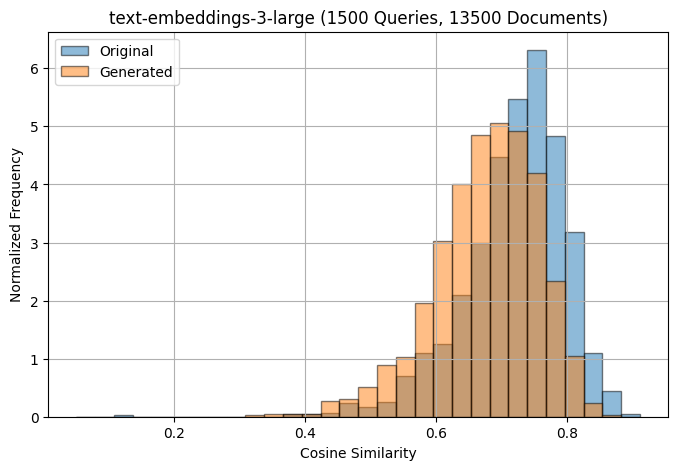

In [86]:
plt.figure(figsize=(8, 5))
plt.hist(openai_large_og_scores_df["score"], bins=bins, alpha=0.5,  edgecolor='black', label="Original", range=(min_score, max_score), density=True)
plt.hist(openai_large_gen_scores_df["score"], bins=bins, alpha=0.5, edgecolor='black', label="Generated", range=(min_score, max_score), density=True)

plt.xlabel("Cosine Similarity")
plt.ylabel("Normalized Frequency")

plt.title("text-embeddings-3-large (1500 Queries, 13500 Documents)")
plt.legend()
plt.grid(True)
plt.show()

### jina no input type

In [76]:
jina_no_input_col = chroma_client.get_collection("jina_text_matching")

In [78]:
jina_no_input_og_queries_embeddings = jina_process_in_batches_no_input(og_queries_text)
jina_no_input_gen_queries_embeddings = jina_process_in_batches_no_input(gen_queries_text)

jina_no_input_og_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, jina_no_input_og_queries_embeddings)
}


jina_no_input_gen_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, jina_no_input_gen_queries_embeddings)
}

jina_no_input_corpus_embeddings_dict = {}

for i in tqdm(range(0, len(all_corpus_ids), batch_size), desc="Processing batches"):
    batch_ids = all_corpus_ids[i:i + batch_size]
    results = jina_no_input_col.get(ids=batch_ids, include=["embeddings"])
    batch_embeddings = results["embeddings"]
    retrieved_ids = results["ids"]

    for corpus_id, embedding in zip(retrieved_ids, batch_embeddings):
        jina_no_input_corpus_embeddings_dict[corpus_id] = embedding


Processing batches: 100%|██████████| 135/135 [03:13<00:00,  1.43s/it]


In [79]:
jina_no_input_og_results = new_get_results(jina_no_input_col, og_queries_text, all_queries_ids, jina_no_input_og_queries_embeddings)
jina_no_input_og_metrics = evaluate_new(k_values, all_qrels_df, jina_no_input_og_results)

jina_no_input_gen_results = new_get_results(jina_no_input_col, gen_queries_text, all_queries_ids, jina_no_input_gen_queries_embeddings)
jina_no_input_gen_metrics = evaluate_new(k_values, all_qrels_df, jina_no_input_gen_results)

jina_no_input_combined_metrics_df = create_combined_metrics_df(jina_no_input_og_metrics, jina_no_input_gen_metrics)
jina_no_input_combined_metrics_df.to_csv("generated_all/jina_no_input_combined_metrics.csv", index=False)

jina_no_input_combined_metrics_df


Processing batches: 100%|██████████| 15/15 [00:21<00:00,  1.47s/it]


,type,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@3,MAP@5,MAP@10,Recall@3,Recall@5,Recall@10,P@3,P@5,P@10
0,original,0.84533,0.90473,0.91044,0.91467,0.89022,0.89336,0.89518,0.94667,0.96067,0.97333,0.31556,0.19213,0.09733
0,generated,0.87200,0.92038,0.92477,0.92706,0.90933,0.91177,0.91279,0.95200,0.96267,0.96933,0.31733,0.19253,0.09693


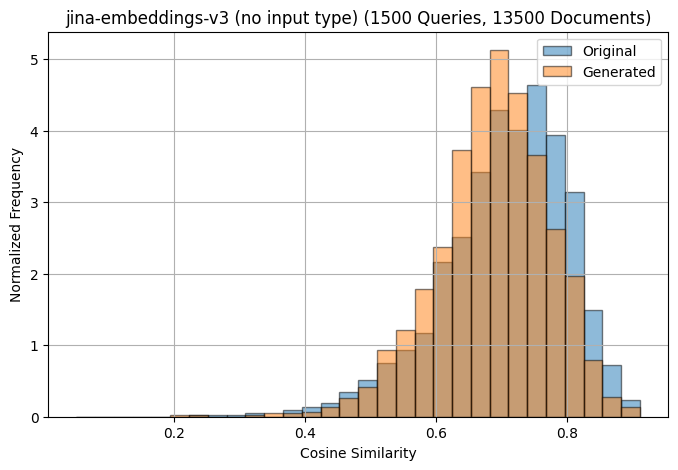

In [87]:
jina_no_input_og_scores_df = calculate_similarity_scores(jina_no_input_og_queries_embeddings_dict, jina_no_input_corpus_embeddings_dict, "generated_all/jina_no_input_og_scores.parquet")
jina_no_input_gen_scores_df = calculate_similarity_scores(jina_no_input_gen_queries_embeddings_dict, jina_no_input_corpus_embeddings_dict, "generated_all/jina_no_input_gen_scores.parquet")

plt.figure(figsize=(8, 5))

plt.hist(jina_no_input_og_scores_df["score"], bins=bins, alpha=0.5,  edgecolor='black', label="Original", range=(min_score, max_score), density=True)
plt.hist(jina_no_input_gen_scores_df["score"], bins=bins, alpha=0.5, edgecolor='black', label="Generated", range=(min_score, max_score), density=True)

plt.xlabel("Cosine Similarity")
plt.ylabel("Normalized Frequency")

plt.title("jina-embeddings-v3 (no input type) (1500 Queries, 13500 Documents)")
plt.legend()
plt.grid(True)
plt.show()

### jina input type

In [81]:
jina_input_col = chroma_client.get_collection("jina")

In [82]:
jina_input_og_queries_embeddings = jina_process_in_batches_input_type(True, og_queries_text)
jina_input_gen_queries_embeddings = jina_process_in_batches_input_type(True, gen_queries_text)

jina_input_og_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, jina_input_og_queries_embeddings)
}

jina_input_gen_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, jina_input_gen_queries_embeddings)
}

jina_input_corpus_embeddings_dict = {}

for i in tqdm(range(0, len(all_corpus_ids), batch_size), desc="Processing batches"):
    batch_ids = all_corpus_ids[i:i + batch_size]
    results = jina_input_col.get(ids=batch_ids, include=["embeddings"])
    batch_embeddings = results["embeddings"]
    retrieved_ids = results["ids"]

    for corpus_id, embedding in zip(retrieved_ids, batch_embeddings):
        jina_input_corpus_embeddings_dict[corpus_id] = embedding

Processing batches: 100%|██████████| 135/135 [03:37<00:00,  1.61s/it]


In [84]:
jina_input_og_results = new_get_results(jina_input_col, og_queries_text, all_queries_ids, jina_input_og_queries_embeddings)
jina_input_og_metrics = evaluate_new(k_values, all_qrels_df, jina_input_og_results)

jina_input_gen_results = new_get_results(jina_input_col, gen_queries_text, all_queries_ids, jina_input_gen_queries_embeddings)
jina_input_gen_metrics = evaluate_new(k_values, all_qrels_df, jina_input_gen_results)

jina_input_combined_metrics_df = create_combined_metrics_df(jina_input_og_metrics, jina_input_gen_metrics)
jina_input_combined_metrics_df.to_csv("generated_all/jina_input_combined_metrics.csv", index=False)

jina_input_combined_metrics_df

Processing batches: 100%|██████████| 15/15 [00:48<00:00,  3.21s/it]


,type,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@3,MAP@5,MAP@10,Recall@3,Recall@5,Recall@10,P@3,P@5,P@10
0,original,0.828,0.88941,0.89845,0.90630,0.87444,0.87944,0.88274,0.93267,0.95467,0.97867,0.31089,0.19093,0.09787
0,generated,0.852,0.90154,0.91181,0.91423,0.89000,0.89577,0.89679,0.93467,0.95933,0.96667,0.31156,0.19187,0.09667


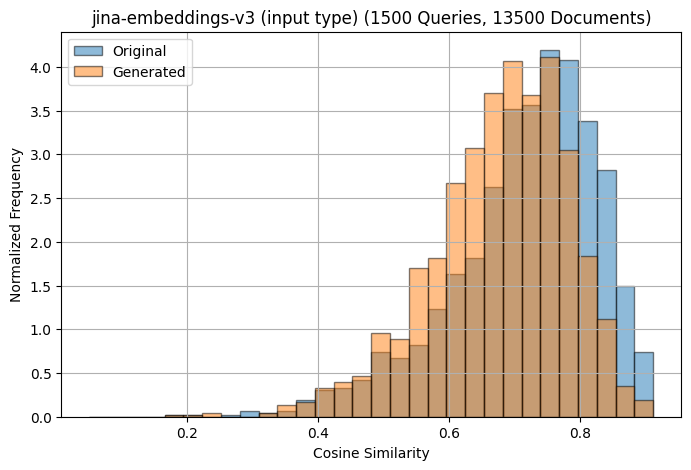

In [88]:
jina_input_og_scores_df = calculate_similarity_scores(jina_input_og_queries_embeddings_dict, jina_input_corpus_embeddings_dict, "generated_all/jina_input_og_scores.parquet")
jina_input_gen_scores_df = calculate_similarity_scores(jina_input_gen_queries_embeddings_dict, jina_input_corpus_embeddings_dict, "generated_all/jina_input_gen_scores.parquet")

plt.figure(figsize=(8, 5))


plt.hist(jina_input_og_scores_df["score"], bins=bins, alpha=0.5,  edgecolor='black', label="Original", range=(min_score, max_score), density=True)
plt.hist(jina_input_gen_scores_df["score"], bins=bins, alpha=0.5, edgecolor='black', label="Generated", range=(min_score, max_score), density=True)

plt.xlabel("Cosine Similarity")
plt.ylabel("Normalized Frequency")

plt.title("jina-embeddings-v3 (input type) (1500 Queries, 13500 Documents)")
plt.legend()
plt.grid(True)
plt.show()

### voyage no input type

In [23]:
voyage_no_input_col = chroma_client.get_collection("voyage_no_input_type")
voyage_client = voyageai.Client(api_key="")

In [ ]:
voyage_no_input_og_queries_embeddings = process_in_batches_voyage_no_input(voyage_client, og_queries_text)
voyage_no_input_gen_queries_embeddings = process_in_batches_voyage_no_input(voyage_client, gen_queries_text)

In [32]:
len(all_corpus_ids)

13500

In [33]:
voyage_no_input_og_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, voyage_no_input_og_queries_embeddings)
}

voyage_no_input_gen_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, voyage_no_input_gen_queries_embeddings)
}

voyage_no_input_corpus_embeddings_dict = {}

for i in tqdm(range(0, len(all_corpus_ids), batch_size), desc="Processing batches"):
    batch_ids = all_corpus_ids[i:i + batch_size]
    results = voyage_no_input_col.get(ids=batch_ids, include=["embeddings"])
    batch_embeddings = results["embeddings"]
    retrieved_ids = results["ids"]
    
    for corpus_id, embedding in zip(retrieved_ids, batch_embeddings):
        voyage_no_input_corpus_embeddings_dict[corpus_id] = embedding

Processing batches: 100%|██████████| 135/135 [03:29<00:00,  1.55s/it]


In [51]:
voyage_no_input_og_results = new_get_results(voyage_no_input_col, og_queries_text, all_queries_ids, voyage_no_input_og_queries_embeddings)
voyage_no_input_og_metrics = evaluate_new(k_values, all_qrels_df, voyage_no_input_og_results)

voyage_no_input_gen_results = new_get_results(voyage_no_input_col, gen_queries_text, all_queries_ids, voyage_no_input_gen_queries_embeddings)
voyage_no_input_gen_metrics = evaluate_new(k_values, all_qrels_df, voyage_no_input_gen_results)


Processing batches: 100%|██████████| 15/15 [00:22<00:00,  1.53s/it]


In [52]:
voyage_no_input_combined_metrics_df = create_combined_metrics_df(
    voyage_no_input_og_metrics,
    voyage_no_input_gen_metrics
)
voyage_no_input_combined_metrics_df


,type,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@3,MAP@5,MAP@10,Recall@3,Recall@5,Recall@10,P@3,P@5,P@10
0,original,0.89400,0.93639,0.94178,0.94601,0.92633,0.92927,0.93109,0.96533,0.97867,0.99133,0.32178,0.19573,0.09913
0,generated,0.92733,0.95908,0.96132,0.96193,0.95178,0.95304,0.95328,0.98000,0.98533,0.98733,0.32667,0.19707,0.09873


In [53]:
voyage_no_input_combined_metrics_df.to_csv("generated_all/voyage_no_input/voyage_no_input_combined_metrics.csv", index=False)

In [54]:
voyage_no_input_og_scores_df = calculate_similarity_scores(
    voyage_no_input_og_queries_embeddings_dict,
    voyage_no_input_corpus_embeddings_dict,
    "generated_all/voyage_no_input/voyage_no_input_og_scores.parquet"
)

voyage_no_input_gen_scores_df = calculate_similarity_scores(
    voyage_no_input_gen_queries_embeddings_dict,
    voyage_no_input_corpus_embeddings_dict,
    "generated_all/voyage_no_input/voyage_no_input_gen_scores.parquet"
)


In [56]:
voyage_no_input_og_scores_df

,query-id,corpus-id,score
4,q20231101.en_45492650_20,20231101.en_45492650_20,0.748613
13,q20231101.en_5843419_78,20231101.en_5843419_78,0.711235
22,q20231101.en_5058739_82,20231101.en_5058739_82,0.709450
31,q20231101.en_62676_84,20231101.en_62676_84,0.739110
40,q20231101.en_8841749_25,20231101.en_8841749_25,0.763942
...,...,...,...
13459,q20231101.en_431272_20,20231101.en_431272_20,0.820929
13468,q20231101.en_1288246_4,20231101.en_1288246_4,0.791254
13477,q20231101.en_3684349_61,20231101.en_3684349_61,0.685230
13486,q20231101.en_159168_15,20231101.en_159168_15,0.583293


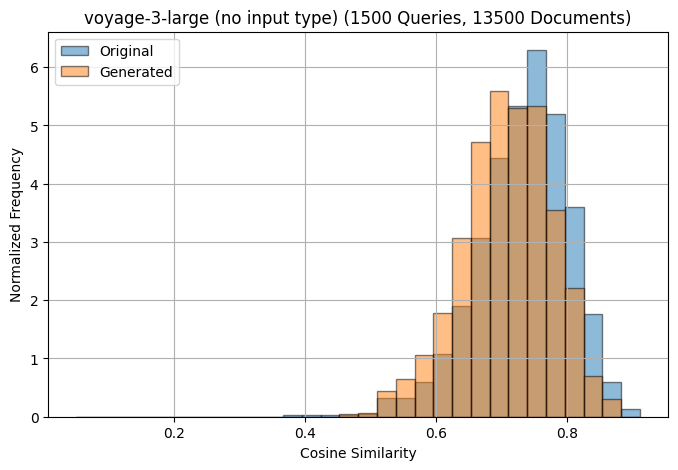

In [63]:
plt.figure(figsize=(8, 5))

plt.hist(voyage_no_input_og_scores_df["score"], bins=bins, alpha=0.5,  edgecolor='black', label="Original", range=(min_score, max_score), density=True)
plt.hist(voyage_no_input_gen_scores_df["score"], bins=bins, alpha=0.5, edgecolor='black', label="Generated", range=(min_score, max_score), density=True)

plt.xlabel("Cosine Similarity")
plt.ylabel("Normalized Frequency")

plt.title("voyage-3-large (no input type) (1500 Queries, 13500 Documents)")
plt.legend()
plt.grid(True)
plt.show()

### voyage input type

In [89]:
voyage_input_col = chroma_client.get_collection("voyage_input_type")

In [92]:
voyage_input_og_queries_embeddings = process_in_batches_voyage_input_type(voyage_client, True, og_queries_text)
voyage_input_gen_queries_embeddings = process_in_batches_voyage_input_type(voyage_client, True, gen_queries_text)

voyage_input_og_queries_embeddings_dict = {
    query_id: embedding
    for query_id, embedding in zip(all_queries_ids, voyage_input_og_queries_embeddings)
}

voyage_input_gen_queries_embeddings_dict = {
    query_id: embedding
    for query_id, embedding in zip(all_queries_ids, voyage_input_gen_queries_embeddings)
}

voyage_input_corpus_embeddings_dict = {}

for i in tqdm(range(0, len(all_corpus_ids), batch_size), desc="Processing batches"):
    batch_ids = all_corpus_ids[i:i + batch_size]
    results = voyage_input_col.get(ids=batch_ids, include=["embeddings"])
    batch_embeddings = results["embeddings"]
    retrieved_ids = results["ids"]

    for corpus_id, embedding in zip(retrieved_ids, batch_embeddings):
        voyage_input_corpus_embeddings_dict[corpus_id] = embedding


Processing batches: 100%|██████████| 135/135 [03:39<00:00,  1.62s/it]


In [ ]:
voyage_input_og_results = new_get_results(voyage_input_col, og_queries_text, all_queries_ids, voyage_input_og_queries_embeddings)
voyage_input_og_metrics = evaluate_new(k_values, all_qrels_df, voyage_input_og_results)

voyage_input_gen_results = new_get_results(voyage_input_col, gen_queries_text, all_queries_ids, voyage_input_gen_queries_embeddings)
voyage_input_gen_metrics = evaluate_new(k_values, all_qrels_df, voyage_input_gen_results)

voyage_input_combined_metrics_df = create_combined_metrics_df(
    voyage_input_og_metrics,
    voyage_input_gen_metrics
)

In [94]:

voyage_input_combined_metrics_df.to_csv("generated_all/voyage_input_combined_metrics.csv", index=False)
voyage_input_combined_metrics_df

,type,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@3,MAP@5,MAP@10,Recall@3,Recall@5,Recall@10,P@3,P@5,P@10
0,original,0.89667,0.93386,0.93943,0.94331,0.92522,0.92836,0.93008,0.95867,0.97200,0.98333,0.31956,0.19440,0.09833
0,generated,0.91000,0.94083,0.94336,0.94383,0.93389,0.93532,0.93554,0.96067,0.96667,0.96800,0.32022,0.19333,0.09680


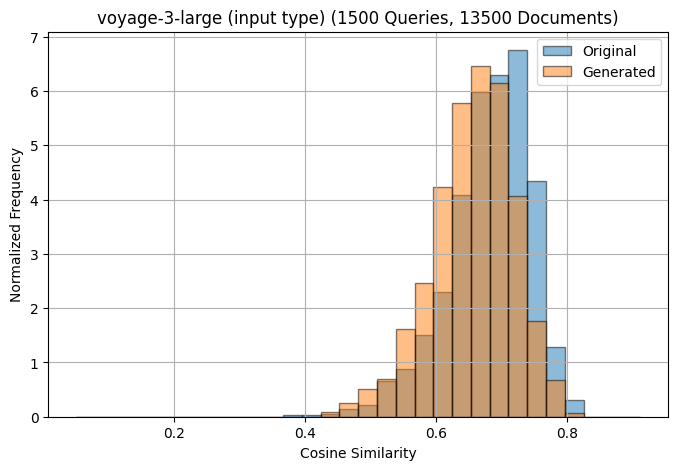

In [97]:
voyage_input_og_scores_df = calculate_similarity_scores(
    voyage_input_og_queries_embeddings_dict,
    voyage_input_corpus_embeddings_dict,
    "generated_all/voyage_input_og_scores.parquet"
)

voyage_input_gen_scores_df = calculate_similarity_scores(
    voyage_input_gen_queries_embeddings_dict,
    voyage_input_corpus_embeddings_dict,
    "generated_all/voyage_input_gen_scores.parquet"
)

    
plt.figure(figsize=(8, 5))

plt.hist(voyage_input_og_scores_df["score"], bins=bins, alpha=0.5,  edgecolor='black', label="Original", range=(min_score, max_score), density=True)
plt.hist(voyage_input_gen_scores_df["score"], bins=bins, alpha=0.5, edgecolor='black', label="Generated", range=(min_score, max_score), density=True)

plt.xlabel("Cosine Similarity")
plt.ylabel("Normalized Frequency")

plt.title("voyage-3-large (input type) (1500 Queries, 13500 Documents)")
plt.legend()
plt.grid(True)
plt.show()

### minilm

In [100]:
minilm_col = chroma_client.get_collection("minilm")

In [101]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [102]:
minilm_og_queries_embeddings = minilm_embed_batch(model, og_queries_text)
minilm_gen_queries_embeddings = minilm_embed_batch(model, gen_queries_text)

minilm_og_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, minilm_og_queries_embeddings)
}

minilm_gen_queries_embeddings_dict = {
    query_id: embedding 
    for query_id, embedding in zip(all_queries_ids, minilm_gen_queries_embeddings)
}

minilm_corpus_embeddings_dict = {}

for i in tqdm(range(0, len(all_corpus_ids), batch_size), desc="Processing batches"):
    batch_ids = all_corpus_ids[i:i + batch_size]
    results = minilm_col.get(ids=batch_ids, include=["embeddings"])
    batch_embeddings = results["embeddings"]
    retrieved_ids = results["ids"]

    for corpus_id, embedding in zip(retrieved_ids, batch_embeddings):
        minilm_corpus_embeddings_dict[corpus_id] = embedding


Processing batches: 100%|██████████| 135/135 [01:46<00:00,  1.27it/s]


In [103]:
minilm_og_results = new_get_results(minilm_col, og_queries_text, all_queries_ids, minilm_og_queries_embeddings)
minilm_og_metrics = evaluate_new(k_values, all_qrels_df, minilm_og_results)

minilm_gen_results = new_get_results(minilm_col, gen_queries_text, all_queries_ids, minilm_gen_queries_embeddings)
minilm_gen_metrics = evaluate_new(k_values, all_qrels_df, minilm_gen_results)

minilm_combined_metrics_df = create_combined_metrics_df(minilm_og_metrics, minilm_gen_metrics)
minilm_combined_metrics_df.to_csv("generated_all/minilm_combined_metrics.csv", index=False)
minilm_combined_metrics_df

Processing batches: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


,type,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@3,MAP@5,MAP@10,Recall@3,Recall@5,Recall@10,P@3,P@5,P@10
0,original,0.77200,0.84768,0.86237,0.87108,0.82933,0.83757,0.84134,0.90067,0.936,0.96200,0.30022,0.1872,0.09620
0,generated,0.82933,0.88760,0.89721,0.89941,0.87400,0.87933,0.88026,0.92667,0.950,0.95667,0.30889,0.1900,0.09567


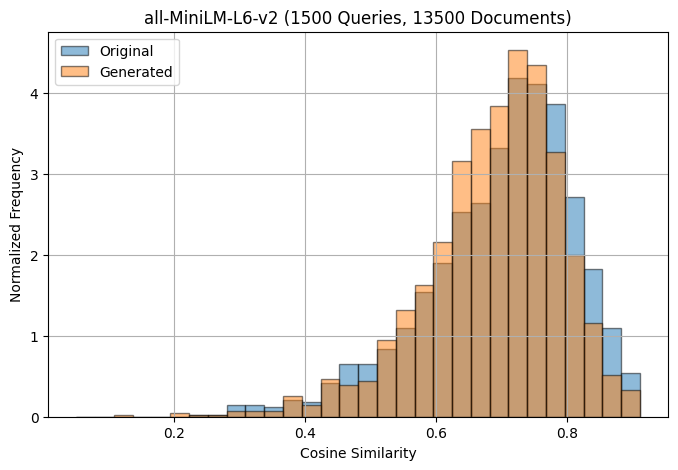

In [ ]:
minilm_og_scores_df = calculate_similarity_scores(minilm_og_queries_embeddings_dict, minilm_corpus_embeddings_dict, "generated_all/minilm_og_scores.parquet")
minilm_gen_scores_df = calculate_similarity_scores(minilm_gen_queries_embeddings_dict, minilm_corpus_embeddings_dict, "generated_all/minilm_gen_scores.parquet")

plt.figure(figsize=(8, 5))



plt.hist(minilm_og_scores_df["score"], bins=bins, alpha=0.5,  edgecolor='black', label="Original", range=(min_score, max_score), density=True)
plt.hist(minilm_gen_scores_df["score"], bins=bins, alpha=0.5, edgecolor='black', label="Generated", range=(min_score, max_score), density=True)

plt.xlabel("Cosine Similarity")
plt.ylabel("Normalized Frequency")

plt.title("all-MiniLM-L6-v2 (1500 Queries, 13500 Documents)")
plt.legend()
plt.grid(True)
plt.show()

### compare across all models

In [107]:
openai_small_combined_metrics_df = pd.read_csv("generated_all/openai_small_combined_metrics.csv")

In [112]:
minilm_combined_metrics_df["model"] = "all-MiniLM-L6-v2"
openai_small_combined_metrics_df["model"] = "text-embedding-3-small" 
openai_large_combined_metrics_df["model"] = "text-embedding-3-large"
jina_input_combined_metrics_df["model"] = "jina-embeddings-v3 (input type)"
jina_no_input_combined_metrics_df["model"] = "jina-embeddings-v3 (no input type)"
voyage_no_input_combined_metrics_df["model"] = "voyage-3-large (no input type)"
voyage_input_combined_metrics_df["model"] = "voyage-3-large (input type)"

all_models_metrics_df = pd.concat([
    minilm_combined_metrics_df,
    openai_small_combined_metrics_df,
    openai_large_combined_metrics_df, 
    jina_input_combined_metrics_df,
    jina_no_input_combined_metrics_df,
    voyage_no_input_combined_metrics_df,
    voyage_input_combined_metrics_df
])

cols = ['model'] + [col for col in all_models_metrics_df.columns if col != 'model']
all_models_metrics_df = all_models_metrics_df[cols]

all_models_metrics_df.to_csv("generated_all/all_models_metrics.csv", index=False)

In [ ]:
openai_large_og_scores_df

In [ ]:
test_df = create_combined_df(openai_large_col, openai_large_og_queries_embeddings_dict, openai_large_gen_queries_embeddings_dict, openai_large_og_scores_df, openai_large_gen_scores_df)

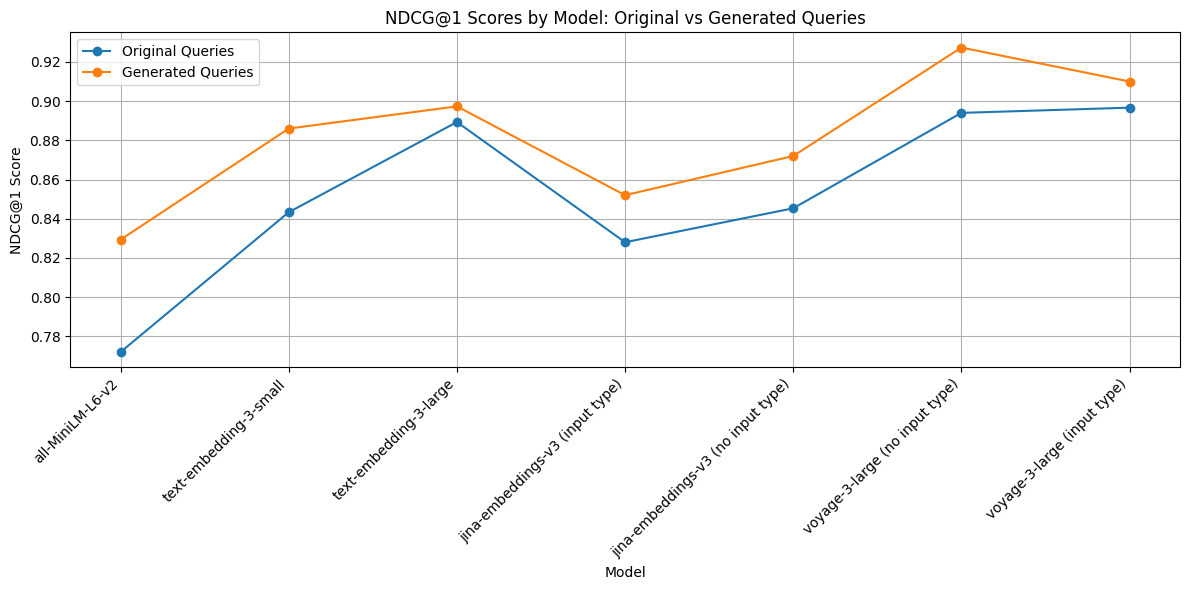

In [159]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

original_data = all_models_metrics_df[all_models_metrics_df['type'] == 'original']
generated_data = all_models_metrics_df[all_models_metrics_df['type'] == 'generated']

plt.plot(original_data['model'], original_data['NDCG@1'], marker='o', label='Original Queries')
plt.plot(generated_data['model'], generated_data['NDCG@1'], marker='o', label='Generated Queries')

plt.xticks(rotation=45, ha='right')
plt.ylabel('NDCG@1 Score')
plt.xlabel('Model')
plt.title('NDCG@1 Scores by Model: Original vs Generated Queries')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()